<h1><center> Emotions in context (Emotic) </center></h1>
<center> Baseline model</center>

# I. Prepare places pretrained model

In [1]:
import os
import requests
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from PIL import Image
from torchvision import transforms as trn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
from torchsummary import summary
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from transformers import DistilBertModel, DistilBertTokenizer

Purpose: Downloads and prepares the pre-trained Places365 ResNet18 model for context feature extraction.

Essential for initializing the context feature extractor.

Summary: This section downloads a pre-trained ResNet18 model on the Places365 dataset, which is used to extract contextual features from images.

In [2]:
# Create a directory to save the model
os.makedirs("places", exist_ok=True)

# URL of the ResNet model
model_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
model_path = "./places/resnet18_places365.pth.tar"

# Download the model if not already downloaded
if not os.path.exists(model_path):
    print("Downloading ResNet model...")
    response = requests.get(model_url, stream=True)
    with open(model_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Download complete.")
else:
    print("Model already exists.")


Model already exists.


In [3]:
# Saving the model weights to use ahead in the notebook

# the architecture to use
arch = 'resnet18'
model_weight = os.path.join('./places', 'resnet18_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet18_state_dict.pth')
print ('completed cell')

completed cell


# II. Emotic classes

## Emotic Model 

Purpose: Creates a neural network model that maps image and text features into a shared embedding space.

Processes image and text inputs through separate pathways, projects them into a common latent space, averages the joint embeddings, and makes emotion predictions from this shared representation.

Summary: This model implements joint embedding fusion by first transforming image and text features to intermediate embeddings, then projecting them to a common dimensional space where they're averaged before making categorical and continuous emotion predictions.

In [4]:
class EmoticJointEmbedding(nn.Module):
    ''' Emotic Model with joint embedding in shared latent space '''
    def __init__(self, context_features, body_features, embedding_dim=256, joint_dim=128):
        super(EmoticJointEmbedding, self).__init__()
        self.context_features = context_features
        self.body_features = body_features
        self.embedding_dim = embedding_dim
        self.joint_dim = joint_dim
        
        # Image pathway to intermediate embedding
        self.img_fc = nn.Linear(body_features, embedding_dim)
        self.img_bn = nn.BatchNorm1d(embedding_dim)
        self.img_relu = nn.ReLU()
        
        # Text pathway to intermediate embedding
        self.text_fc = nn.Linear(context_features, embedding_dim)
        self.text_bn = nn.BatchNorm1d(embedding_dim)
        self.text_relu = nn.ReLU()
        
        # Projection to joint space
        self.img_to_joint = nn.Linear(embedding_dim, joint_dim)
        self.text_to_joint = nn.Linear(embedding_dim, joint_dim)
        
        # Output layers from joint space
        self.fc_cat = nn.Linear(joint_dim, 26)
        self.fc_cont = nn.Linear(joint_dim, 3)

    def forward(self, x_context, x_body, return_embeddings=False):
        # Process context features (text)
        context_features = x_context.view(-1, self.context_features)
        text_embedding = self.text_fc(context_features)
        text_embedding = self.text_bn(text_embedding)
        text_embedding = self.text_relu(text_embedding)
        
        # Process body features (image)
        body_features = x_body.view(-1, self.body_features)
        img_embedding = self.img_fc(body_features)
        img_embedding = self.img_bn(img_embedding)
        img_embedding = self.img_relu(img_embedding)
        
        # Project to joint space
        joint_text = self.text_to_joint(text_embedding)
        joint_img = self.img_to_joint(img_embedding)
        
        # Average the embeddings in joint space
        joint_embedding = (joint_text + joint_img) / 2
        
        # Output predictions from joint space
        cat_out = self.fc_cat(joint_embedding)
        cont_out = self.fc_cont(joint_embedding)
        
        if return_embeddings:
            return cat_out, cont_out, joint_text, joint_img, text_embedding, img_embedding
        return cat_out, cont_out


## Emotic Dataset

Purpose: Custom dataset class for loading preprocessed EMOTIC data.

Needed for data loading.

Summary: This dataset class handles loading preprocessed context images, body images, categorical emotion labels, and continuous emotion dimensions from NumPy arrays, applying appropriate transformations and normalization

In [5]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_context, x_body, y_cat, y_cont, transform, context_norm, body_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_context = x_context
    self.x_body = x_body
    self.y_cat = y_cat 
    self.y_cont = y_cont
    self.transform = transform 
    self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])  # Normalizing the context image with context mean and context std
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])           # Normalizing the body image with body mean and body std

  def __len__(self):
    return len(self.y_cat)
  
  def __getitem__(self, index):
    image_context = self.x_context[index]
    image_body = self.x_body[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    return self.context_norm(self.transform(image_context)), self.body_norm(self.transform(image_body)), torch.tensor(cat_label, dtype=torch.float32), torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


## Emotic Losses

Purpose: Custom loss functions for categorical and continuous emotion predictions.

Necessary for model training.

Summary: 
1. DiscreteLoss: Custom loss for categorical emotion prediction that supports different weighting schemes (mean, static, dynamic) to handle class imbalance in multi-label classification.

2. ContinuousLoss_L2: L2-based loss function for continuous emotion dimensions (valence, arousal, dominance) that ignores errors below a margin threshold.

3. ContinuousLoss_SL1: Smooth L1 loss for continuous emotion dimensions that combines L2 loss for small errors and L1 loss for large errors, reducing sensitivity to outliers.

4. ContrastiveLoss: InfoNCE-based contrastive loss that aligns text and image embeddings in the joint space by maximizing similarity between matching pairs while minimizing similarity between non-matching pairs.

In [6]:
class DiscreteLoss(nn.Module):
  ''' Class to measure loss between categorical emotion predictions and labels.'''
  def __init__(self, weight_type='mean', device=torch.device('cpu')):
    super(DiscreteLoss, self).__init__()
    self.weight_type = weight_type
    self.device = device
    if self.weight_type == 'mean':
      self.weights = torch.ones((1,26))/26.0
      self.weights = self.weights.to(self.device)
    elif self.weight_type == 'static':
      self.weights = torch.FloatTensor([0.1435, 0.1870, 0.1692, 0.1165, 0.1949, 0.1204, 0.1728, 0.1372, 0.1620,
         0.1540, 0.1987, 0.1057, 0.1482, 0.1192, 0.1590, 0.1929, 0.1158, 0.1907,
         0.1345, 0.1307, 0.1665, 0.1698, 0.1797, 0.1657, 0.1520, 0.1537]).unsqueeze(0)
      self.weights = self.weights.to(self.device)
    
  def forward(self, pred, target):
    if self.weight_type == 'dynamic':
      self.weights = self.prepare_dynamic_weights(target)
      self.weights = self.weights.to(self.device)
    loss = (((pred - target)**2) * self.weights)
    return loss.sum() 

  def prepare_dynamic_weights(self, target):
    target_stats = torch.sum(target, dim=0).float().unsqueeze(dim=0).cpu()
    weights = torch.zeros((1,26))
    weights[target_stats != 0 ] = 1.0/torch.log(target_stats[target_stats != 0].data + 1.2)
    weights[target_stats == 0] = 0.0001
    return weights


class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin
  
  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2 
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()


class ContinuousLoss_SL1(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using smooth l1 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_SL1, self).__init__()
    self.margin = margin
  
  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = 0.5 * (labs ** 2)
    loss[ (labs > self.margin) ] = labs[ (labs > self.margin) ] - 0.5
    return loss.sum()

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, joint_text, joint_img):
        # Normalize embeddings
        joint_text = F.normalize(joint_text, p=2, dim=1)
        joint_img = F.normalize(joint_img, p=2, dim=1)
        
        # Compute similarity matrix
        similarity = torch.matmul(joint_text, joint_img.t())
        
        # Labels: diagonal elements (matching pairs) should have high similarity
        labels = torch.arange(similarity.size(0)).to(similarity.device)
        
        # InfoNCE loss
        loss = F.cross_entropy(similarity / 0.07, labels) + F.cross_entropy(similarity.t() / 0.07, labels)
        return loss / 2.0


print ('completed cell')

completed cell


# III. Load preprocessed data

Purpose: Loads preprocessed EMOTIC data from NumPy arrays.

Update path to your data location.

Summary: This section loads preprocessed context images, body images, categorical labels, and continuous dimensions for training, validation, and testing sets, and creates mappings between emotion names and indices.

In [15]:
# Change data_src variable as per your drive
data_src = 'D:/Ruturaj/New folder (3)/Ruturaj/Smart Systems/MANAV Experiment/proj/data/emotic19/emotic_pre'

# Load training preprocessed data
train_context = np.load(os.path.join(data_src,'train_context_arr.npy'))
train_body = np.load(os.path.join(data_src,'train_body_arr.npy'))
train_cat = np.load(os.path.join(data_src,'train_cat_arr.npy'))
train_cont = np.load(os.path.join(data_src,'train_cont_arr.npy'))

# Load validation preprocessed data
val_context = np.load(os.path.join(data_src,'val_context_arr.npy'))
val_body = np.load(os.path.join(data_src,'val_body_arr.npy'))
val_cat = np.load(os.path.join(data_src,'val_cat_arr.npy'))
val_cont = np.load(os.path.join(data_src,'val_cont_arr.npy'))

# Load testing preprocessed data
test_context = np.load(os.path.join(data_src,'test_context_arr.npy'))
test_body = np.load(os.path.join(data_src,'test_body_arr.npy'))
test_cat = np.load(os.path.join(data_src,'test_cat_arr.npy'))
test_cont = np.load(os.path.join(data_src,'test_cont_arr.npy'))

# Categorical emotion classes
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
       'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
       'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
    cat2ind[emotion] = idx
    ind2cat[idx] = emotion

print('train ', 'context ', train_context.shape, 'body', train_body.shape, 'cat ', train_cat.shape, 'cont', train_cont.shape)
print('val ', 'context ', val_context.shape, 'body', val_body.shape, 'cat ', val_cat.shape, 'cont', val_cont.shape)
print('test ', 'context ', test_context.shape, 'body', test_body.shape, 'cat ', test_cat.shape, 'cont', test_cont.shape)
print('completed cell')

train  context  (23266, 224, 224, 3) body (23266, 128, 128, 3) cat  (23266, 26) cont (23266, 3)
val  context  (3315, 224, 224, 3) body (3315, 128, 128, 3) cat  (3315, 26) cont (3315, 3)
test  context  (7203, 224, 224, 3) body (7203, 128, 128, 3) cat  (7203, 26) cont (7203, 3)
completed cell


Purpose: Sets up data transformations, normalization, and data loaders.

Essential for proper data handling.

Summary: This section defines image transformations (including data augmentation for training), normalization parameters, and creates PyTorch DataLoader objects for efficient batch processing during training and evaluation.

In [16]:
batch_size = 26

context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
body_mean = [0.43832874, 0.3964344, 0.3706214]
body_std = [0.24784276, 0.23621225, 0.2323653]
context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]

train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_context, train_body, train_cat, train_cont,
                                  train_transform, context_norm, body_norm)
val_dataset = Emotic_PreDataset(val_context, val_body, val_cat, val_cont,
                                test_transform, context_norm, body_norm)
test_dataset = Emotic_PreDataset(test_context, test_body, test_cat, test_cont,
                                 test_transform, context_norm, body_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print('completed cell')

train loader  894 val loader  128 test 278
completed cell


# IV. Prepare emotic model

Purpose:  Initializes and prepares the feature extraction models and the joint embedding emotion recognition model.

Loads pre-trained ResNet18 models for context and body features, creates a joint embedding model with specified dimensions, and removes the classification layers from the feature extractors.

Summary: This section sets up the complete model architecture by loading pre-trained visual feature extractors and initializing the EmoticJointEmbedding model that will map features from both modalities into a shared 128-dimensional latent space.

In [17]:
model_path_places = './places'

model_context = models.__dict__[arch](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet18_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = models.resnet18(pretrained=True)

# Create the new model with separate embeddings
emotic_model = EmoticJointEmbedding(
    list(model_context.children())[-1].in_features, 
    list(model_body.children())[-1].in_features,
    embedding_dim=256,
    joint_dim=128
)

model_context = nn.Sequential(*(list(model_context.children())[:-1]))
model_body = nn.Sequential(*(list(model_body.children())[:-1]))

# print (summary(model_context, (3,224,224), device="cpu"))
# print (summary(model_body, (3,128,128), device="cpu"))

print ('completed cell')

c:\Users\admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


completed cell


## Prepare optimizer

Purpose: Configures which model parameters to train and sets up optimization.

Necessary for training.

Summary: This section freezes the pre-trained feature extractors (context and body models) while making the fusion model (emotic_model) trainable. It also initializes the Adam optimizer, learning rate scheduler, and loss functions.

In [18]:
for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False
for param in model_body.parameters():
  param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_context.parameters()) + \
                  list(model_body.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_SL1 = ContinuousLoss_SL1()
contrastive_loss = ContrastiveLoss()

print ('completed cell')

completed cell


# V. Train model

Purpose: Trains a multi-modal emotion recognition model with joint embedding.

Iteratively processes batches of image-text pairs, computes task losses (categorical and continuous) plus contrastive loss for alignment, updates model parameters, evaluates on validation data, and saves the best model.

Summary: This function implements a complete training pipeline that not only optimizes for emotion recognition accuracy but also enforces alignment between image and text embeddings in a shared latent space through contrastive learning, tracking performance and saving model checkpoints when validation loss improves.

In [19]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, contrastive_loss, cat_loss_param=0.5, cont_loss_param=0.5, contrastive_param=0.1):
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    
    min_loss = np.inf
    train_loss = list()
    val_loss = list()

    model_context, model_body, emotic_model = models

    for e in range(epochs):
        running_loss = 0.0

        emotic_model.to(device)
        model_context.to(device)
        model_body.to(device)
        
        emotic_model.train()
        model_context.train()
        model_body.train()
        
        for images_context, images_body, labels_cat, labels_cont in iter(train_loader):
            images_context = images_context.to(device)
            images_body = images_body.to(device)
            labels_cat = labels_cat.to(device)
            labels_cont = labels_cont.to(device)

            opt.zero_grad()

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)

            cat_out, cont_out, joint_text, joint_img, _, _ = emotic_model(pred_context, pred_body, return_embeddings=True)
            
            # Task losses
            cat_loss_batch = disc_loss(cat_out, labels_cat)
            cont_loss_batch = cont_loss(cont_out * 10, labels_cont * 10)
            
            # Contrastive loss for joint embedding
            align_loss = contrastive_loss(joint_text, joint_img)
            
            # Combined loss
            loss = (cat_loss_param * cat_loss_batch) + (cont_loss_param * cont_loss_batch) + (contrastive_param * align_loss)
            running_loss += loss.item()
            loss.backward()
            opt.step()

        if e % 1 == 0: 
            print(f'epoch = {e} training loss = {running_loss:.4f}')
        train_loss.append(running_loss)

        
        running_loss = 0.0 
        emotic_model.eval()
        model_context.eval()
        model_body.eval()
        
        with torch.no_grad():
            for images_context, images_body, labels_cat, labels_cont in iter(val_loader):
                images_context = images_context.to(device)
                images_body = images_body.to(device)
                labels_cat = labels_cat.to(device)
                labels_cont = labels_cont.to(device)

                pred_context = model_context(images_context)
                pred_body = model_body(images_body)
                
                # For the new model that returns embeddings
                if hasattr(emotic_model, 'return_embeddings'):
                    pred_cat, pred_cont, _, _ = emotic_model(pred_context, pred_body, return_embeddings=True)
                else:
                    pred_cat, pred_cont = emotic_model(pred_context, pred_body)
                    
                cat_loss_batch = disc_loss(pred_cat, labels_cat)
                cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
                loss = (cat_loss_param * cat_loss_batch) + (cont_loss_param * cont_loss_batch)
                running_loss += loss.item()

            if e % 1 == 0:
                print(f'epoch = {e} validation loss = {running_loss:.4f}')
        val_loss.append(running_loss)
          
        scheduler.step()

        if val_loss[-1] < min_loss:
            min_loss = val_loss[-1]
            # saving models for lowest loss
            print(f'saving model at epoch e = {e}')
            emotic_model.to("cpu")
            model_context.to("cpu")
            model_body.to("cpu")
            torch.save(emotic_model, os.path.join(model_path, 'model_emotic1.pth'))
            torch.save(model_context, os.path.join(model_path, 'model_context1.pth'))
            torch.save(model_body, os.path.join(model_path, 'model_body1.pth'))

    print('completed training')
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))
    f.suptitle('emotic')
    ax1.plot(range(0, len(train_loss)), train_loss, color='Blue')
    ax2.plot(range(0, len(val_loss)), val_loss, color='Red')
    ax1.legend(['train'])
    ax2.legend(['val'])
    plt.savefig(os.path.join(model_path, 'loss_curves.png'))

epoch = 0 training loss = 49350.1612
epoch = 0 validation loss = 6027.8655
saving model at epoch e = 0
epoch = 1 training loss = 44306.7012
epoch = 1 validation loss = 6057.9102
epoch = 2 training loss = 43443.0932
epoch = 2 validation loss = 5848.8917
saving model at epoch e = 2
epoch = 3 training loss = 42729.9789
epoch = 3 validation loss = 5864.0000
epoch = 4 training loss = 42443.2408
epoch = 4 validation loss = 5848.3692
saving model at epoch e = 4
epoch = 5 training loss = 42072.8576
epoch = 5 validation loss = 6108.8788
epoch = 6 training loss = 41824.9621
epoch = 6 validation loss = 5557.9750
saving model at epoch e = 6
epoch = 7 training loss = 40241.8120
epoch = 7 validation loss = 5579.9596
epoch = 8 training loss = 39845.3997
epoch = 8 validation loss = 5660.5102
epoch = 9 training loss = 39642.3608
epoch = 9 validation loss = 5689.1188
epoch = 10 training loss = 39368.3587
epoch = 10 validation loss = 5769.1969
epoch = 11 training loss = 39226.4440
epoch = 11 validation l

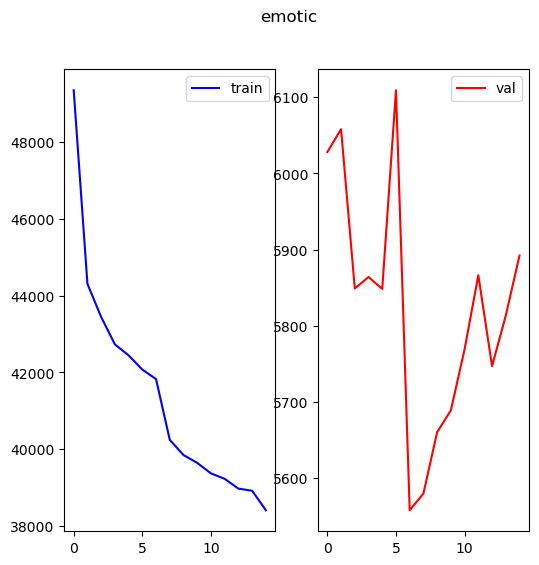

In [20]:
train_emotic(15, './models', opt, scheduler, [model_context, model_body, emotic_model], disc_loss, cont_loss_SL1, contrastive_loss)

# VI. Test model

Purpose: Functions to evaluate model performance.

Needed for performance assessment.

Summary: These functions calculate Mean Average Precision for categorical emotions, Mean Absolute Error for continuous dimensions (VAD), and optimal thresholds for emotion classification.

In [21]:
def test_scikit_ap(cat_preds, cat_labels):
    ap = np.zeros(26, dtype=np.float32)
    for i in range(26):
        ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
    print('ap', ap, ap.shape, ap.mean())
    return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
    vad = np.zeros(3, dtype=np.float32)
    for i in range(3):
        vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
    print('vad', vad, vad.shape, vad.mean())
    return vad.mean()


def get_thresholds(cat_preds, cat_labels):
    thresholds = np.zeros(26, dtype=np.float32)
    for i in range(26):
        p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
        for k in range(len(p)):
            if p[k] == r[k]:
                thresholds[i] = t[k]
                break
    np.save('./thresholds.npy', thresholds)
    return thresholds

print ('completed cell')

completed cell


Purpose: Evaluates the model on a dataset and saves predictions.

Processes images through the model, collects predictions and ground truth labels, calculates Mean Average Precision (AP) for categorical emotions and Mean Absolute Error (MAE) for continuous VAD dimensions, and saves results to MAT files.

Summary: This function runs inference on a dataset, handling both categorical emotion predictions and continuous VAD predictions, while properly managing device placement, batching, and evaluation metrics.

In [22]:
def test_data(models, device, data_loader, num_images):
    model_context, model_body, emotic_model = models
    cat_preds = np.zeros((num_images, 26))
    cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_body.eval()
        emotic_model.eval()
        indx = 0
        print('starting testing')
        for images_context, images_body, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)
            images_body = images_body.to(device)

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            
            # For the new model that returns embeddings
            if hasattr(emotic_model, 'return_embeddings'):
                pred_cat, pred_cont, _, _ = emotic_model(pred_context, pred_body, return_embeddings=True)
            else:
                pred_cat, pred_cont = emotic_model(pred_context, pred_body)

            cat_preds[indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            cat_labels[indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10 
            indx = indx + pred_cat.shape[0]

    cat_preds = cat_preds.transpose()
    cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    scipy.io.savemat('./cat_preds.mat', mdict={'cat_preds': cat_preds})
    scipy.io.savemat('./cat_labels.mat', mdict={'cat_labels': cat_labels})
    scipy.io.savemat('./cont_preds.mat', mdict={'cont_preds': cont_preds})
    scipy.io.savemat('./cont_labels.mat', mdict={'cont_labels': cont_labels})
    print('completed testing')
    ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print(ap_mean, vad_mean)
    return ap_mean, vad_mean

print ('completed cell')

completed cell


# VII. Analysis

Purpose: Extracts joint embeddings from the model for analysis.

Processes images and text through the model, collecting the joint embeddings, predictions, and true labels up to a specified number of samples.

Summary: This function runs inference on a dataset, extracting the aligned text and image embeddings from the joint embedding space, along with model predictions and ground truth labels, enabling further analysis of the embedding space characteristics and model performance.

In [23]:
def analyze_joint_embeddings(models, device, data_loader, num_samples=1000):
    model_context, model_body, emotic_model = models
    
    joint_text_embeddings = []
    joint_img_embeddings = []
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_body.eval()
        emotic_model.eval()
        
        count = 0
        for images_context, images_body, labels_cat, _ in iter(data_loader):
            if count >= num_samples:
                break
                
            images_context = images_context.to(device)
            images_body = images_body.to(device)
            
            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            
            cat_out, cont_out, joint_text, joint_img, _, _ = emotic_model(pred_context, pred_body, return_embeddings=True)
            
            joint_text_embeddings.append(joint_text.cpu().numpy())
            joint_img_embeddings.append(joint_img.cpu().numpy())
            predictions.append(cat_out.cpu().numpy())
            true_labels.append(labels_cat.cpu().numpy())
            
            count += images_context.size(0)
    
    joint_text_embeddings = np.vstack(joint_text_embeddings)
    joint_img_embeddings = np.vstack(joint_img_embeddings)
    predictions = np.vstack(predictions)
    true_labels = np.vstack(true_labels)
    
    return joint_text_embeddings, joint_img_embeddings, predictions, true_labels


Purpose: Evaluates how well text and image embeddings align in the joint space.

Calculates cross-modal retrieval metrics by computing cosine similarities between text and image embeddings, then measuring how often the correct matching pairs are retrieved.

Summary: This function normalizes embeddings, computes a similarity matrix, and calculates mean similarity and recall@k metrics (1, 5, and 10) to quantify how effectively the joint embedding space aligns corresponding text-image pairs.

In [24]:
def compute_alignment_metrics(joint_text, joint_img):
    # Normalize embeddings
    joint_text_norm = joint_text / np.linalg.norm(joint_text, axis=1, keepdims=True)
    joint_img_norm = joint_img / np.linalg.norm(joint_img, axis=1, keepdims=True)
    
    # Compute similarity matrix
    similarity = np.matmul(joint_text_norm, joint_img_norm.T)
    
    # Compute retrieval metrics
    diagonal = np.diagonal(similarity)
    mean_similarity = np.mean(diagonal)
    
    # Compute recall@k
    recall_at_1 = 0
    recall_at_5 = 0
    recall_at_10 = 0
    
    for i in range(similarity.shape[0]):
        # Sort similarities for this text embedding
        sorted_indices = np.argsort(similarity[i])[::-1]
        
        # Check if correct image is in top k
        if i in sorted_indices[:1]:
            recall_at_1 += 1
        if i in sorted_indices[:5]:
            recall_at_5 += 1
        if i in sorted_indices[:10]:
            recall_at_10 += 1
    
    num_samples = similarity.shape[0]
    recall_at_1 /= num_samples
    recall_at_5 /= num_samples
    recall_at_10 /= num_samples
    
    return {
        'mean_similarity': mean_similarity,
        'recall@1': recall_at_1,
        'recall@5': recall_at_5,
        'recall@10': recall_at_10
    }

Purpose: Visualizes text and image embeddings in a shared 2D space.

Applies t-SNE dimensionality reduction to joint embeddings, plots text and image points in different colors, and connects corresponding pairs with lines.

Summary: This function creates an intuitive visualization of how well the joint embedding space aligns corresponding text and image representations, with shorter connecting lines indicating better alignment between modalities.

In [25]:
def visualize_joint_space(joint_text, joint_img, labels):
    # Apply t-SNE
    from sklearn.manifold import TSNE
    
    # Combine embeddings for t-SNE
    combined = np.vstack([joint_text, joint_img])
    
    # Create labels for visualization
    modality_labels = np.array(['Text'] * len(joint_text) + ['Image'] * len(joint_img))
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(combined)
    
    # Split back
    text_2d = embeddings_2d[:len(joint_text)]
    img_2d = embeddings_2d[len(joint_text):]
    
    # Visualize
    plt.figure(figsize=(10, 8))
    plt.scatter(text_2d[:, 0], text_2d[:, 1], c='blue', alpha=0.5, label='Text')
    plt.scatter(img_2d[:, 0], img_2d[:, 1], c='red', alpha=0.5, label='Image')
    
    # Draw lines between corresponding pairs
    for i in range(min(len(text_2d), len(img_2d))):
        plt.plot([text_2d[i, 0], img_2d[i, 0]], [text_2d[i, 1], img_2d[i, 1]], 'k-', alpha=0.1)
    
    plt.title('Joint Embedding Space')
    plt.legend()
    plt.savefig('joint_embedding_space.png')
    plt.show()


# VIII. Run the analysis

Purpose: Loads pre-trained models and evaluates their performance on validation and test datasets.

Loads three model components (context encoder, body encoder, and fusion model) from saved files, imports evaluation metrics, and runs evaluation to calculate Mean Average Precision (AP) and Mean VAD MAE on both validation and test sets.

Summary: This code initializes the model components and establishes baseline performance metrics for emotion recognition, providing a foundation for further analysis of the joint embedding space.

In [29]:
# Load models
print('Loading trained models')
model_context = torch.load('./models/model_context1.pth', weights_only=False)
model_body = torch.load('./models/model_body1.pth', weights_only=False)
emotic_model = torch.load('./models/model_emotic1.pth', weights_only=False)

from sklearn.metrics import precision_score, recall_score, f1_score
# Run baseline evaluation to get AP and VAD metrics
print('Running baseline evaluation')
val_ap, val_vad = test_data([model_context, model_body, emotic_model], device, val_loader, val_dataset.__len__())
test_ap, test_vad = test_data([model_context, model_body, emotic_model], device, test_loader, test_dataset.__len__())
print('Validation Mean average precision=%.4f Mean VAD MAE=%.4f' % (val_ap, val_vad))
print('Testing Mean average precision=%.4f Mean VAD MAE=%.4f' % (test_ap, test_vad))

Loading trained models
Running baseline evaluation
starting testing
completed testing
ap [0.39712372 0.19204298 0.20735845 0.948654   0.15555418 0.7876879
 0.24256536 0.3576591  0.19611233 0.18616034 0.05263802 0.9715028
 0.24752462 0.78795564 0.14133482 0.07275402 0.8055173  0.16924226
 0.2860225  0.46783453 0.21031684 0.08320583 0.20161903 0.15099624
 0.38556975 0.11805441] (26,) 0.3393464
vad [0.74037385 0.8828994  0.8433137 ] (3,) 0.8221957
0.3393464 0.8221957
starting testing
completed testing
ap [0.2829318  0.09808533 0.1350515  0.5690258  0.06127004 0.7521687
 0.1205946  0.23090667 0.15465146 0.16600515 0.02236207 0.8443593
 0.14769134 0.6786512  0.10288128 0.05212402 0.66444457 0.06362464
 0.20820545 0.39850286 0.18213008 0.05114826 0.19005094 0.0780846
 0.12134977 0.08532364] (26,) 0.24852404
vad [0.93683857 1.0499464  0.9581794 ] (3,) 0.9816548
0.24852404 0.9816548
Validation Mean average precision=0.3393 Mean VAD MAE=0.8222
Testing Mean average precision=0.2485 Mean VAD MAE=

Purpose: Analyzes the quality of the joint embedding space.

Extracts joint embeddings from the model, computes alignment metrics between text and image modalities, and prints the results.

Summary: This code evaluates how well the model aligns text and image representations in the shared latent space by extracting embeddings for 500 samples and calculating metrics like mean similarity and recall@k, which indicate how effectively the model maps corresponding cross-modal pairs to nearby points in the embedding space.

In [30]:
# Analyze joint embeddings
print('Analyzing joint embedding space')
joint_text, joint_img, predictions, labels = analyze_joint_embeddings(
    [model_context, model_body, emotic_model], 
    device, 
    test_loader,
    num_samples=500
)

# Compute alignment metrics
alignment_metrics = compute_alignment_metrics(joint_text, joint_img)
print("\nJoint Embedding Alignment Metrics:")
for metric, value in alignment_metrics.items():
    print(f"{metric}: {value:.4f}")

Analyzing joint embedding space

Joint Embedding Alignment Metrics:
mean_similarity: 0.5515
recall@1: 0.0154
recall@5: 0.0519
recall@10: 0.0788


Purpose: Evaluate and display detailed performance metrics for each emotion category.

Calculates accuracy, precision, recall, and F1 score for each emotion, sorts them by F1 score, and prints a formatted table of results.

Summary: This code provides a comprehensive breakdown of how well the model performs on each individual emotion, helping identify which emotions are recognized most accurately and which ones need improvement.

In [31]:
# Calculate per-emotion performance
emotion_performance = []
for i, emotion in enumerate(cat):
    accuracy = np.mean((predictions[:, i] > 0.5) == (labels[:, i] > 0.5))
    precision = precision_score(labels[:, i] > 0.5, predictions[:, i] > 0.5, zero_division=0)
    recall = recall_score(labels[:, i] > 0.5, predictions[:, i] > 0.5, zero_division=0)
    f1 = f1_score(labels[:, i] > 0.5, predictions[:, i] > 0.5, zero_division=0)
    emotion_performance.append((emotion, accuracy, precision, recall, f1))

# Sort by F1 score
emotion_performance.sort(key=lambda x: x[4], reverse=True)

print("\nPer-Emotion Performance (Joint Model):")
print("Emotion\t\tAccuracy\tPrecision\tRecall\t\tF1")
for emotion, acc, prec, rec, f1 in emotion_performance:
    print(f"{emotion:<15} {acc:.4f}\t\t{prec:.4f}\t\t{rec:.4f}\t\t{f1:.4f}")


Per-Emotion Performance (Joint Model):
Emotion		Accuracy	Precision	Recall		F1
Engagement      0.5385		0.8465		0.5168		0.6418
Happiness       0.5596		0.8421		0.0661		0.1226
Anticipation    0.5500		0.7143		0.0617		0.1136
Suffering       0.9654		1.0000		0.0526		0.1000
Excitement      0.5500		0.3333		0.0043		0.0085
Confidence      0.5346		1.0000		0.0041		0.0082
Affection       0.8846		0.0000		0.0000		0.0000
Anger           0.9808		0.0000		0.0000		0.0000
Annoyance       0.9577		0.0000		0.0000		0.0000
Aversion        0.9692		0.0000		0.0000		0.0000
Disapproval     0.9577		0.0000		0.0000		0.0000
Disconnection   0.8404		0.0000		0.0000		0.0000
Disquietment    0.8827		0.0000		0.0000		0.0000
Doubt/Confusion 0.8423		0.0000		0.0000		0.0000
Embarrassment   0.9769		0.0000		0.0000		0.0000
Esteem          0.8577		0.0000		0.0000		0.0000
Fatigue         0.9346		0.0000		0.0000		0.0000
Fear            0.9673		0.0000		0.0000		0.0000
Pain            0.9808		0.0000		0.0000		0.0000
Peace           0.8385		0.00

Purpose: Analyzes the quality and complexity of the joint embedding space.

Applies PCA to determine how many dimensions are needed to capture 95% of the variance in the joint embeddings.

Summary: This code measures the effective dimensionality of the joint embedding space, which indicates how efficiently the model represents multimodal information and helps assess the embedding quality.

In [32]:
# Calculate embedding quality metrics
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# Dimensionality reduction analysis
pca = PCA().fit(np.vstack([joint_text, joint_img]))
explained_variance = np.cumsum(pca.explained_variance_ratio_)
effective_dim = np.argmax(explained_variance >= 0.95) + 1
print(f"\nEffective dimensionality of joint space (95% variance): {effective_dim}")


Effective dimensionality of joint space (95% variance): 71


Purpose: Evaluate the separability of emotion classes in the joint embedding space.

It combines text and image embeddings, performs KNN classification using cross-validation, and reports the average accuracy.

Summary: This code assesses how well the joint embeddings distinguish between different emotions by using a K-Nearest Neighbors classifier, providing a measure of the embedding space's effectiveness in separating emotion categories.

In [33]:
# Embedding separability - KNN classification
X = np.vstack([joint_text, joint_img])
y = np.argmax(np.vstack([labels, labels]), axis=1)  # Convert one-hot to class indices
knn = KNeighborsClassifier(n_neighbors=5)
from sklearn.model_selection import cross_val_score
knn_scores = cross_val_score(knn, X, y, cv=5)
print(f"KNN classification accuracy in joint space: {np.mean(knn_scores):.4f}")

c:\Users\admin\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


KNN classification accuracy in joint space: 0.3346


Purpose: Evaluates cross-modal retrieval performance between text and image embeddings.

Normalizes embeddings, computes similarity matrix, and calculates Recall@k metrics (k=1,5,10) for both text-to-image and image-to-text retrieval.

Summary: This code measures how well the joint embedding space enables finding corresponding items across modalities, which is a key indicator of successful multi-modal alignment in the shared latent space.

In [34]:
# Cross-modal retrieval evaluation
from sklearn.metrics.pairwise import cosine_similarity

# Normalize embeddings
joint_text_norm = joint_text / np.linalg.norm(joint_text, axis=1, keepdims=True)
joint_img_norm = joint_img / np.linalg.norm(joint_img, axis=1, keepdims=True)

# Compute similarity matrix
similarity = np.matmul(joint_text_norm, joint_img_norm.T)

# Calculate retrieval metrics
print("\nCross-Modal Retrieval Metrics:")
for k in [1, 5, 10]:
    # Text to Image retrieval
    text_to_img_recall = 0
    for i in range(similarity.shape[0]):
        sorted_indices = np.argsort(similarity[i])[::-1]
        if i in sorted_indices[:k]:
            text_to_img_recall += 1
    text_to_img_recall /= similarity.shape[0]
    
    # Image to Text retrieval
    img_to_text_recall = 0
    for i in range(similarity.shape[1]):
        sorted_indices = np.argsort(similarity[:, i])[::-1]
        if i in sorted_indices[:k]:
            img_to_text_recall += 1
    img_to_text_recall /= similarity.shape[1]
    
    print(f"Recall@{k}: Text→Image: {text_to_img_recall:.4f}, Image→Text: {img_to_text_recall:.4f}")


Cross-Modal Retrieval Metrics:
Recall@1: Text→Image: 0.0154, Image→Text: 0.0154
Recall@5: Text→Image: 0.0519, Image→Text: 0.0404
Recall@10: Text→Image: 0.0788, Image→Text: 0.0865


1. Visualize joint space
    Purpose: Creates a visual representation of the joint embedding space.
    Calls the visualize_joint_space function to plot text and image embeddings in a 2D space.
    Summary: Visualizes how text and image embeddings are distributed and aligned in the shared latent space.

2. Visualize embedding quality
    Purpose: Shows the effectiveness of dimensionality reduction in the joint space.
    Plots the cumulative explained variance from PCA analysis.
    Summary: Helps determine how many dimensions are needed to capture most of the variance in the embeddings.

3. Visualize similarity matrix
    Purpose: Displays the cross-modal similarity between text and image embeddings.
    Creates a heatmap of the similarity matrix between modalities.
    Summary: Shows how well each text embedding matches with each image embedding, with diagonal elements ideally having higher values.

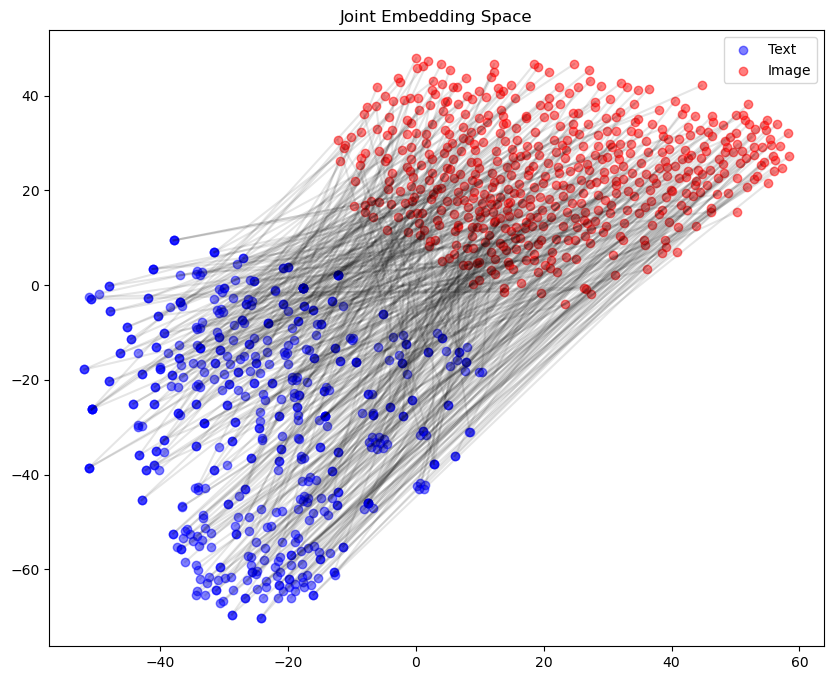

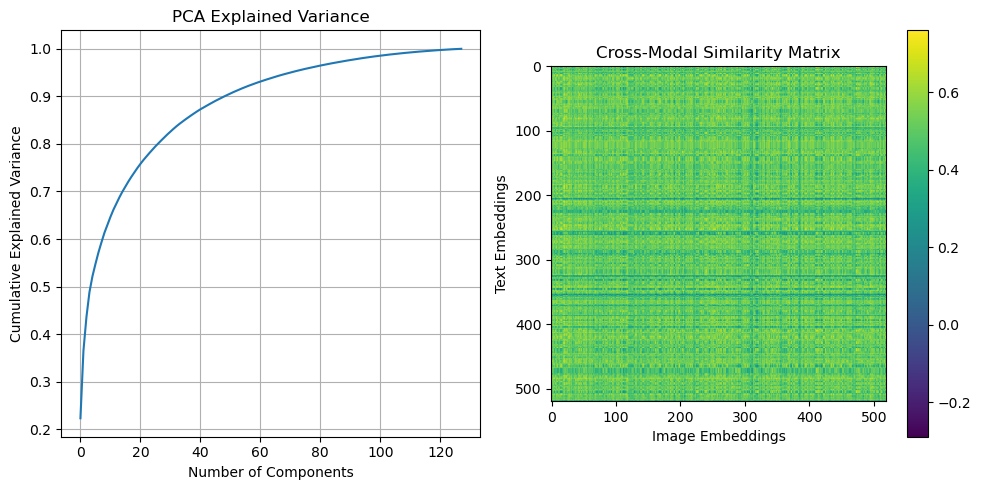

In [35]:
# Visualize joint space
visualize_joint_space(joint_text, joint_img, labels)

# Visualize embedding quality
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)

# Visualize similarity matrix
plt.subplot(1, 2, 2)
plt.imshow(similarity, cmap='viridis')
plt.colorbar()
plt.title('Cross-Modal Similarity Matrix')
plt.xlabel('Image Embeddings')
plt.ylabel('Text Embeddings')
plt.tight_layout()
plt.savefig('joint_embedding_analysis.png')
plt.show()

Purpose: Visualize emotion-specific embeddings in the joint space.
Creates a 2D t-SNE plot of joint embeddings, highlighting the top 5 most prevalent emotions with different colors.
Summary: This code reduces the dimensionality of joint text and image embeddings using t-SNE, then visualizes them in a scatter plot where points are colored based on the top 5 most common emotions, providing insight into how well the joint embedding space separates different emotions.

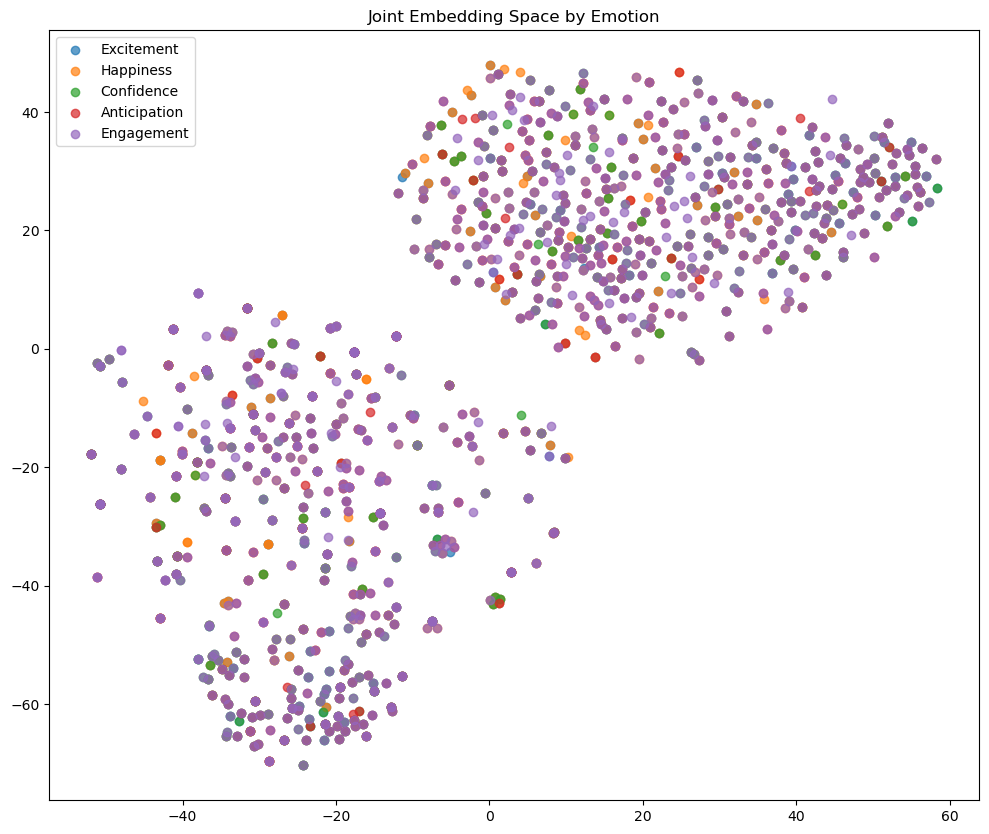

In [36]:
# Visualize emotion-specific embeddings
from sklearn.manifold import TSNE

# Get top 5 emotions by prevalence
emotion_counts = np.sum(labels > 0.5, axis=0)
top_emotions_idx = np.argsort(emotion_counts)[-5:]
top_emotions = [cat[i] for i in top_emotions_idx]

# Create t-SNE visualization colored by emotion
tsne = TSNE(n_components=2, random_state=42)
joint_embeddings = np.vstack([joint_text, joint_img])
joint_labels = np.vstack([labels, labels])
embeddings_2d = tsne.fit_transform(joint_embeddings)

plt.figure(figsize=(12, 10))
for i, emotion_idx in enumerate(top_emotions_idx):
    emotion_name = cat[emotion_idx]
    mask = joint_labels[:, emotion_idx] > 0.5
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], label=emotion_name, alpha=0.7)

plt.title('Joint Embedding Space by Emotion')
plt.legend()
plt.savefig('joint_embedding_emotions.png')
plt.show()

In [37]:
# Summary of findings
print("\nSummary of Joint Embedding Analysis:")
print(f"1. Overall Performance: AP={test_ap:.4f}, VAD MAE={test_vad:.4f}")
print(f"2. Cross-Modal Alignment: Mean Similarity={alignment_metrics['mean_similarity']:.4f}")
print(f"3. Retrieval Performance: Recall@1={alignment_metrics['recall@1']:.4f}")
print(f"4. Effective Dimensionality: {effective_dim} dimensions")
print(f"5. Best Performing Emotions: {', '.join([e[0] for e in emotion_performance[:3]])}")
print(f"6. Worst Performing Emotions: {', '.join([e[0] for e in emotion_performance[-3:]])}")



Summary of Joint Embedding Analysis:
1. Overall Performance: AP=0.2485, VAD MAE=0.9817
2. Cross-Modal Alignment: Mean Similarity=0.5515
3. Retrieval Performance: Recall@1=0.0154
4. Effective Dimensionality: 71 dimensions
5. Best Performing Emotions: Engagement, Happiness, Anticipation
6. Worst Performing Emotions: Surprise, Sympathy, Yearning
